### Introduction

Chronic kidney disease (CKD) refers to a gradual loss and impairment of the kidneys' functions in filtering wastes and excess fluids from the blood. In the intial stages of CKD, signs and symtoms can be minimal. However, in advanced CKD, as dangerous levels of fluid and wastes build up within the body, symptoms can include persistent high blood pressure (hypertension) that is difficult to control, shortness of breath due to fluiud build-up in the lungs, among others. Conditions and diseases often associated with an increased risk of CKD include: type 1 or type 2 diabetes, high blood pressure/hypertension, smoking, obesity, older age, as well as, cardiovascular disease. Utilizing ckd_clean.csv, which includes data regarding measures of 400 patients, 250 of those with CKD (Class 1) and the remaining 150 rows without CKD (Class 0), we will attempt to classify a new observation/patient as possessing CKD or not possessing CKD. The measures we will be utilizing in order to perform this classification are age, blood pressure, albumin, blood urea, hypertension, diabetes mellitus, coronary artery disease, and the presence of pus cells in urine. 

# Preliminary Exploratory Data Analysis

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
ckd_data <- read_csv("ckd_clean.csv")
names(ckd_data) <- make.names(names(ckd_data), unique = TRUE)
ckd_data

Parsed with column specification:
cols(
  .default = col_double(),
  `Red Blood Cells` = col_character(),
  `Pus Cell` = col_character(),
  `Pus Cell clumps` = col_character(),
  Bacteria = col_character(),
  Hypertension = col_character(),
  `Diabetes Mellitus` = col_character(),
  `Coronary Artery Disease` = col_character(),
  Appetite = col_character(),
  `Pedal Edema` = col_character(),
  Anemia = col_character()
)

See spec(...) for full column specifications.



Age,Blood.Pressure,Specific.Gravity,Albumin,Sugar,Red.Blood.Cells,Pus.Cell,Pus.Cell.clumps,Bacteria,Blood.Glucose.Random,⋯,Packed.Cell.Volume,White.Blood.Cell.Count,Red.Blood.Cell.Count,Hypertension,Diabetes.Mellitus,Coronary.Artery.Disease,Appetite,Pedal.Edema,Anemia,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,⋯,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.020,2,0,abnormal,abnormal,present,notpresent,70,⋯,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.010,3,0,abnormal,abnormal,present,notpresent,380,⋯,32,4500,3.8,yes,yes,no,poor,yes,no,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,80,1.020,0,0,normal,normal,notpresent,notpresent,100,⋯,49,6600,5.4,no,no,no,good,no,no,0
17,60,1.025,0,0,normal,normal,notpresent,notpresent,114,⋯,51,7200,5.9,no,no,no,good,no,no,0
58,80,1.025,0,0,normal,normal,notpresent,notpresent,131,⋯,53,6800,6.1,no,no,no,good,no,no,0


In [4]:
#summarize the data in at least one table.
set.seed(150)
ckd_split <- initial_split(ckd_data, prop = 0.30, strata = Diabetes.Mellitus)  
ckd_training <- training(ckd_split)

ckd_ex_summarize <- ckd_training %>% 
                 group_by(Diabetes.Mellitus) %>%
                 summarize(n = n()) 
ckd_ex_summarize

`summarise()` ungrouping output (override with `.groups` argument)



Diabetes.Mellitus,n
<chr>,<int>
no,39
yes,9


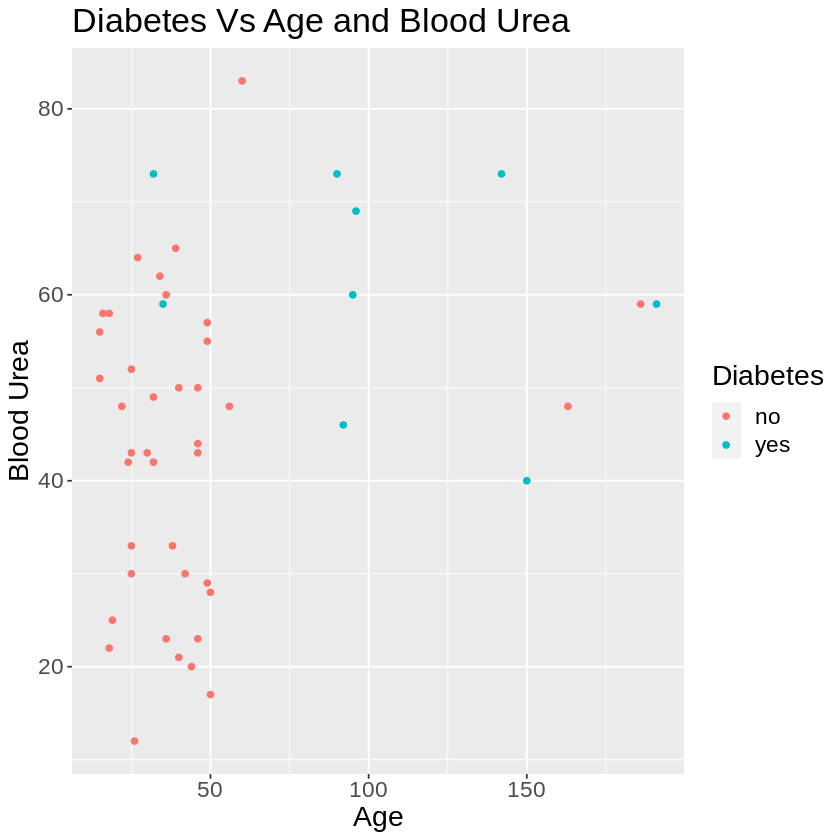

In [5]:
#visualize the data with at least one plot relevant to the analysis you plan to do.
ckd_ex_plot <- ckd_training %>%
               ggplot(aes(x = Blood.Urea, y = Age, colour = Diabetes.Mellitus)) +
               geom_point() +
               labs(x = "Age", y = "Blood Urea", title = "Diabetes Vs Age and Blood Urea", colour = "Diabetes") +
               theme(text = element_text(size = 17))
ckd_ex_plot

# Methods

Some factors that can influence whether a person has chronic kidney disease are age, blood pressure, diabetes, albumin, blood urea, hypertension, diabetes mellitus, coronary artery disease. As such, we will utilize these as variables in order to determine if they possess a relationship with CKD and can be used as reliable indicators for CKD. We plan on utilizing classification in order to predict whether a new patient/observation point on our graph is likely to possess CKD or not. 

For our visualization we plan on making a scatter plot with age on the x axis, blood pressure on the y axis, and color code our points on the plot to indicate whether they have diabetes or not. Another potential scatter plot visualization we may utilize would have age on the x-axis, blood urea on the y-axis, with the points’ shape and color indicating whether the individual has CDK or not.


# Expected outcomes and significance 

We believe that based on the measured variables in this data set, the higher value of each observed in a patient can lead to possessing CKD.  The impact of such finding could lead to advances in the medical field and finding new ways to treat patients. Future studies can look more in depth on variables that were shown to have a higher influence. 